In [ ]:
!unzip "select_cropped.zip" -d ""

In [65]:
!pip install easyfsl

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [66]:
#!pip install -U albumentations

In [67]:
from pathlib import Path

from easyfsl.datasets import EasySet, FewShotDataset

# pylint: disable=invalid-name
def ANIME(split: str, **kwargs) -> FewShotDataset:
    specs_file = Path(f"{split}.json")
    if specs_file.is_file():
        return EasySet(specs_file=specs_file, **kwargs)

    raise ValueError(f"Could not find specs file {specs_file.name} in content")

In [68]:
import torch
from torch import nn, optim, Tensor
from torchvision import transforms

from easyfsl.utils import plot_images, sliding_average

from torch.utils.data import Dataset
import matplotlib.pyplot as plt
%matplotlib inline
from pathlib import Path
import random
from statistics import mean

import numpy as np
from tqdm import tqdm

In [69]:
random_seed = 0
np.random.seed(random_seed)
torch.manual_seed(random_seed)
random.seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [70]:
n_way = 5
n_shot = 1
n_query = 10

DEVICE = "cuda"
n_workers = 2

In [71]:
# Instantiate the datasets
train_set = ANIME(split="train", training=True)
val_set = ANIME(split="val", training=False)

In [72]:
from easyfsl.samplers import TaskSampler
from torch.utils.data import DataLoader


n_tasks_per_epoch = 100
n_validation_tasks = 100

train_sampler = TaskSampler(
    train_set, n_way=n_way, n_shot=n_shot, n_query=n_query, n_tasks=n_tasks_per_epoch
)
val_sampler = TaskSampler(
    val_set, n_way=n_way, n_shot=n_shot, n_query=n_query, n_tasks=n_validation_tasks
)

train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=n_workers,
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)
val_loader = DataLoader(
    val_set,
    batch_sampler=val_sampler,
    num_workers=n_workers,
    pin_memory=True,
    collate_fn=val_sampler.episodic_collate_fn,
)

In [73]:
img_mean = (0.485, 0.456, 0.406)
img_std = (0.229, 0.224, 0.225)

def plot_images_mod(images: Tensor, title: str, images_per_row: int):
    plt.figure()
    plt.title(title)
    plt.imshow(
        torchvision.utils.make_grid([image * torch.tensor(img_std).view(3, 1, 1)+ torch.tensor(img_mean).view(3, 1, 1) for image in images], nrow=images_per_row).permute(1, 2, 0)
    )

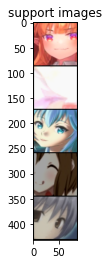

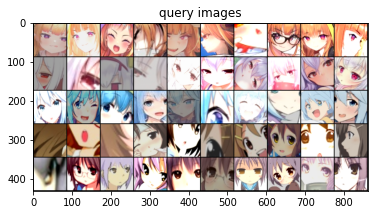

In [74]:
(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(train_loader))

plot_images_mod(example_support_images, "support images", images_per_row=n_shot)
plot_images_mod(example_query_images, "query images", images_per_row=n_query)


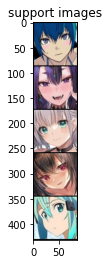

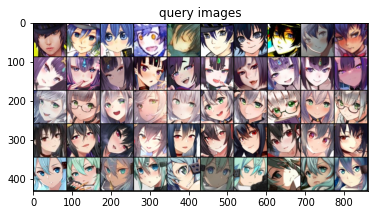

In [75]:
(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(val_loader))

plot_images_mod(example_support_images, "support images", images_per_row=n_shot)
plot_images_mod(example_query_images, "query images", images_per_row=n_query)


In [79]:
from easyfsl.methods import PrototypicalNetworks, FewShotClassifier
from easyfsl.modules import resnet12


convolutional_network = resnet12()
few_shot_classifier = PrototypicalNetworks(convolutional_network).to(DEVICE)

In [80]:
from torch.optim import SGD, Optimizer
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter


LOSS_FUNCTION = nn.CrossEntropyLoss()

n_epochs = 100
scheduler_milestones = [50, 80]
scheduler_gamma = 0.1
learning_rate = 1e-2
tb_logs_dir = Path(".")

train_optimizer = SGD(
    few_shot_classifier.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4
)
train_scheduler = MultiStepLR(
    train_optimizer,
    milestones=scheduler_milestones,
    gamma=scheduler_gamma,
)

tb_writer = SummaryWriter(log_dir=str(tb_logs_dir))

In [81]:
def training_epoch(
    model: FewShotClassifier, data_loader: DataLoader, optimizer: Optimizer
):
    all_loss = []
    model.train()
    with tqdm(
        enumerate(data_loader), total=len(data_loader), desc="Training"
    ) as tqdm_train:
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            _,
        ) in tqdm_train:
            optimizer.zero_grad()
            model.process_support_set(
                support_images.to(DEVICE), support_labels.to(DEVICE)
            )
            classification_scores = model(query_images.to(DEVICE))

            loss = LOSS_FUNCTION(classification_scores, query_labels.to(DEVICE))
            loss.backward()
            optimizer.step()

            all_loss.append(loss.item())

            tqdm_train.set_postfix(loss=mean(all_loss))

    return mean(all_loss)

In [ ]:
from easyfsl.methods.utils import evaluate


best_state = few_shot_classifier.state_dict()
best_validation_accuracy = 0.0
for epoch in range(n_epochs):
    print(f"Epoch {epoch}")
    average_loss = training_epoch(few_shot_classifier, train_loader, train_optimizer)
    validation_accuracy = evaluate(
        few_shot_classifier, val_loader, device=DEVICE, tqdm_prefix="Validation"
    )

    if validation_accuracy > best_validation_accuracy:
        best_validation_accuracy = validation_accuracy
        best_state = few_shot_classifier.state_dict()
        torch.save(best_state, "checkpoint.pth")
        print("Ding ding ding! We found a new best model!")

    tb_writer.add_scalar("Train/loss", average_loss, epoch)
    tb_writer.add_scalar("Val/acc", validation_accuracy, epoch)

    # Warn the scheduler that we did an epoch
    # so it knows when to decrease the learning rate
    train_scheduler.step()

torch.save(best_state, "checkpoint.pth")

In [ ]:
torch.save(best_state, "checkpoint.pth")

In [83]:
few_shot_classifier.load_state_dict(torch.load("checkpoint_5_1.pth"))

<All keys matched successfully>

In [ ]:
few_shot_classifier.load_state_dict(best_state)

In [84]:
n_test_tasks = 1000

test_set = ANIME(split="test", training=False)
test_sampler = TaskSampler(
    test_set, n_way=n_way, n_shot=n_shot, n_query=n_query, n_tasks=n_test_tasks
)
test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    num_workers=n_workers,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)

In [85]:
img_mean = (0.485, 0.456, 0.406)
img_std = (0.229, 0.224, 0.225)

def plot_images_mod(images: Tensor, title: str, images_per_row: int):
    plt.figure()
    plt.title(title)
    plt.imshow(
        torchvision.utils.make_grid([image * torch.tensor(img_std).view(3, 1, 1)+ torch.tensor(img_mean).view(3, 1, 1) for image in images], nrow=images_per_row).permute(1, 2, 0)
    )

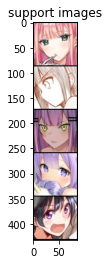

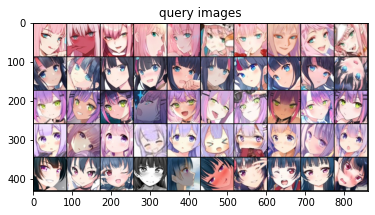

In [86]:
(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(test_loader))

plot_images_mod(example_support_images, "support images", images_per_row=n_shot)
plot_images_mod(example_query_images, "query images", images_per_row=n_query)


In [87]:
from easyfsl.methods.utils import evaluate

accuracy = evaluate(few_shot_classifier, test_loader, device=DEVICE)
print(f"Average accuracy : {(100 * accuracy):.2f} %")

100%|██████████| 1000/1000 [04:10<00:00,  3.99it/s, accuracy=0.757]

Average accuracy : 75.72 %
